In [1]:
import os
from random import sample
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Must be set before importing TF to supress messages
os.environ["CUDA_VISIBLE_DEVICES"]= '4'

import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger
import numpy as np
from utils.loader import DataLoader
from utils.tools import test_model, insert_attention_layer_in_keras, insert_standard_attention_layer_in_keras
from utils.data_sampler import CustomDataGenerator, CustomIterator
from utils.configs import config
from models.layers import ProjectionAttentionLayer
from typing import List
import pymf
import pandas as pd
import rsatoolbox
import matplotlib.pyplot as plt
import pickle
import matplotlib

def test_model(model, test_set: CustomIterator, class_name) -> None:
    """ Test the passed model for its Top-1 accuracy on the passed test set.

    Args:
        model (Model): TensorFlow model.
        test_set (CustomIterator): Test set to test on.
    """
    test_set.reset()
    pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    pred = np.argmax(pred, axis=-1)
    
    print('Computing accuracy...')
    accuracy = np.sum(pred == test_set.class_indices[class_name])/len(pred)

    return accuracy

In [11]:
# Set configs
img_height = 224
img_width = 224
batch_size = 128

test_datagen = CustomDataGenerator(
                preprocessing_function=tf.keras.applications.vgg16.preprocess_input, dtype=tf.float32)

# Load ImageNet dataset with the VGG augmentation
loader = DataLoader(batch_size, (img_height, img_width))
test_set = loader.load_test_set(aug_test=test_datagen, set_batch_size=False)

Loading test set...
Found 48238 images belonging to 1000 classes.


In [21]:
# Load step-up matrix
with open('external_files/generated_saves/proj_mats_norm.pkl', 'rb') as f:
    p_mat_dict  = pickle.load(f)

In [22]:
# Get list of class folders
folder_names = list(os.walk(os.path.join(config['image_net_path'], config['test_path'])))[0][1]
folder_names = sorted(folder_names)

In [23]:
dims = [17,42,90,256, 512]
# Get conversion of folder to names
conv_table = pd.read_table(os.path.join(config['externals'], 'imagenet1k_folder2labels.txt'), names=['folder', 'num', 'label'], delim_whitespace=True)
label_dict = dict(zip(list(conv_table['folder']), list(conv_table['label'])))

In [24]:
classes = ['n01534433', 'n01608432', 'n01806143', 'n01820546', 'n01833805', 'n01855672', 'n02012849', 'n03887697', 'n03207941','n02906734', 'n04131690', 'n03775546', 'n04553703', 'n03207743', 'n02085620', 'n02085782', 'n02085936', 'n02087046', 'n02094114', 'n02095570', 'n02096294'] 
ave = ['n01534433', 'n01608432', 'n01806143', 'n01820546', 'n01833805', 'n01855672', 'n02012849'] 
kitchen = ['n03887697', 'n03207941','n02906734', 'n04131690', 'n03775546', 'n04553703', 'n03207743']
dogs = ['n02085620', 'n02085782', 'n02085936', 'n02087046', 'n02094114', 'n02095570', 'n02096294']
classes2 = [label_dict[cl].lower() for cl in classes]
ave2 = [label_dict[cl].lower() for cl in ave]
kitchen2 = [label_dict[cl].lower() for cl in kitchen]
dogs2 = [label_dict[cl].lower() for cl in dogs]

In [4]:
print(ave2, dogs2 ,kitchen2)

['junco', 'kite', 'peacock', 'lorikeet', 'hummingbird', 'goose', 'crane'] ['chihuahua', 'japanese_spaniel', 'maltese_dog', 'toy_terrier', 'norfolk_terrier', 'lakeland_terrier', 'australian_terrier'] ['paper_towel', 'dishwasher', 'broom', 'saltshaker', 'mixing_bowl', 'washbasin', 'dishrag']


In [14]:
# Metrics (just incase)
acc = []
fp = []
acc_baseline = []
fp_baseline = []
for i in range(3):
    acc.append(pd.read_csv(f'acc{i}.csv', names=['group', 'class', 17, 42, 90, 256, 512], header=0))
    fp.append(pd.read_csv(f'false_alarm{i}.csv', names=['group', 'class', 17, 42, 90, 256, 512], header=0))
    acc_baseline.append(pd.read_csv(f'acc_baseline{i}.csv', names=['group', 'class',17, 42, 90, 256, 512], header=0))
    fp_baseline.append(pd.read_csv(f'false_alarm_base{i}.csv', names=['group', 'class', 17, 42, 90, 256, 512], header=0))

In [25]:
dims = [17, 42, 90, 256, 512, '512-S']

In [26]:
# Load all attention weights (seeds then standard)
s_dict = {d:{} for d in dims}

for dim in [17, 42, 90, 256, 512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in classes:
        s_dict[dim][cl] = []
        for i, j in enumerate(['', '2', '3']):
            model.load_weights(f'models/task_models_fixed/{cl}/{dim}/model_weights{j}')
            s_dict[dim][cl].append(model.get_layer('attention_block5_conv1').seeds.numpy())

model = tf.keras.models.load_model('models/vgg_trained')
model.trainable = False
model = insert_standard_attention_layer_in_keras(model, ['block5_conv1'])

for cl in classes:
    s_dict['512-S'][cl] = []
    for i, j in enumerate(['', '2', '3']):
            model.load_weights(f'models/task_models_standard/{cl}/model_weights{j}' )
            s_dict['512-S'][cl].append(model.get_layer('attention_block5_conv1').kernel.numpy())

In [6]:
# Save dicts
with open('external_files/generated_saves/seed_vals.pkl', 'wb') as f:
    pickle.dump(s_dict, f)

In [35]:
with open('external_files/generated_saves/seed_vals.pkl', 'rb') as f:
    s_dict  = pickle.load(f)

In [37]:
# Get list of class folders
folder_names = list(os.walk(os.path.join(config['image_net_path'], config['test_path'])))[0][1]

sem_vec = np.load('external_files/imagenet2vec_1k.npy')
sem_dict = {}
for cl in folder_names:
    sem_dict[cl] = sem_vec[folder_names.index(cl)]

RSA

In [27]:
# for k, v in sem_dict.items():
#     sem_dict[k] = (sem_dict[k] - np.min(sem_dict[k]))/(np.max(sem_dict[k]) - np.min(sem_dict[k]))

# for d in dims:
#     for k, v in s_dict[d].items():
#         s_dict[d][k] = (s_dict[d][k] - np.min(s_dict[d][k]))/(np.max(s_dict[d][k]) - np.min(s_dict[d][k]))

In [38]:
# Construct data dictionaries
seed_dat = {d:{} for d in dims}
sem_dat = {}

for d in dims:
    seed_dat[d]['all'] = [np.vstack([seed[i] for seed in s_dict[d].values()]) for i in range(3)]
    seed_dat[d]['ave'] = [np.vstack([seed[i] for k, seed in s_dict[d].items() if k in ave]) for i in range(3)]
    seed_dat[d]['kitchen'] = [np.vstack([seed[i] for k, seed in s_dict[d].items() if k in kitchen]) for i in range(3)]
    seed_dat[d]['dog'] = [np.vstack([seed[i] for k, seed in s_dict[d].items() if k in dogs]) for i in range(3)]

sem_dat['all'] = np.vstack([sem_dict[cl] for cl in classes])
sem_dat['ave'] = np.vstack([sem_dict[cl] for cl in classes if cl in ave])
sem_dat['kitchen'] = np.vstack([sem_dict[cl] for cl in classes if cl in kitchen])
sem_dat['dog'] = np.vstack([sem_dict[cl] for cl in classes if cl in dogs])

In [39]:
# Label folds
folds_a = [1]*21
folds_a.extend([2]*21)
folds_a.extend([3]*21)

folds = [1]*7
folds.extend([2]*7)
folds.extend([3]*7)

In [44]:
# Construct Semantic and Seeds RDMs
seed_rdm = {d:{} for d in dims}
sem_rdm = {}
#obs_descriptors={'class':classes, 'super':['ave' if cl in ave else 'kitchen' for cl in classes]

for g in ['all', 'ave', 'kitchen', 'dog']:
    # Semantic vectors
    data = rsatoolbox.data.Dataset(sem_dat[g], obs_descriptors={'class': classes2 if g=='all' else ave2 if g=='ave' else dogs2 if g=='dog' else kitchen2})
    sem_rdm[g] = rsatoolbox.rdm.calc_rdm(data, method='mahalanobis', descriptor='class', noise=None)

    for dim in dims:
        # Seeds
        dat = np.vstack([seed_dat[dim][g][i] for i in range(3)])
        data = rsatoolbox.data.Dataset(dat, obs_descriptors={'class': classes2*3 if g=='all' else ave2*3 if g=='ave' else dogs2*3 if g=='dog' else kitchen2*3, 'fold':folds_a if g=='all' else folds})
        seed_rdm[dim][g] = rsatoolbox.rdm.calc_rdm(data, method='crossnobis', descriptor='class', cv_descriptor='fold', )

Comparisons:
- All, Ave, Kitchen: Seed[dim] vs Sem for all dims to get correlations
- Ave, Kitchen (ALL): Seed vs Seed at different dimensions and against eachother

In [45]:
# Compare seed RDMs to corresponding semantic RDMs
seed_sem = {'ave':[], 'kitchen':[], 'dog':[], 'all':[]}

for g in ['ave', 'kitchen', 'dog', 'all']:
    for d in dims:
        seed_sem[g].append(float(rsatoolbox.rdm.compare(seed_rdm[d][g], sem_rdm[g], method='rho-a')))

In [46]:
# Concat all RDMs across dimensionalities to estimate the noise
con = rsatoolbox.rdm.concat([rsatoolbox.rdm.RDMs(seed_rdm[d]['ave'].get_matrices(), rdm_descriptors={'name':str(d)}, pattern_descriptors=seed_rdm[d]['ave'].pattern_descriptors, dissimilarity_measure="crossnobis") for d in dims],)
con2 = rsatoolbox.rdm.concat([rsatoolbox.rdm.RDMs(seed_rdm[d]['kitchen'].get_matrices(), rdm_descriptors={'name':str(d)}, pattern_descriptors=seed_rdm[d]['kitchen'].pattern_descriptors, dissimilarity_measure="crossnobis") for d in dims],)
con3 = rsatoolbox.rdm.concat([rsatoolbox.rdm.RDMs(seed_rdm[d]['dog'].get_matrices(), rdm_descriptors={'name':str(d)}, pattern_descriptors=seed_rdm[d]['dog'].pattern_descriptors, dissimilarity_measure="crossnobis") for d in dims],)
con4 = rsatoolbox.rdm.concat([rsatoolbox.rdm.RDMs(seed_rdm[d]['all'].get_matrices(), rdm_descriptors={'name':str(d)}, pattern_descriptors=seed_rdm[d]['all'].pattern_descriptors, dissimilarity_measure="crossnobis") for d in dims],)

# Compute noise levels on concatenated RDMs across dimensionalities for a superordinate against the ground-truth model
noise = {}
ls = ['ave', 'kitchen', 'dog', 'all']

for i, v in enumerate([con, con2, con3, con4]):
    train_set, test_set, ceil_set = rsatoolbox.inference.sets_leave_one_out_rdm(v)
    results_cv = rsatoolbox.inference.crossval(rsatoolbox.model.ModelInterpolate('test', v), v, train_set, test_set, ceil_set=ceil_set, method='rho-a')
    noise[ls[i]] = results_cv.noise_ceiling

Text(0.08, 0.5, 'Correlation')

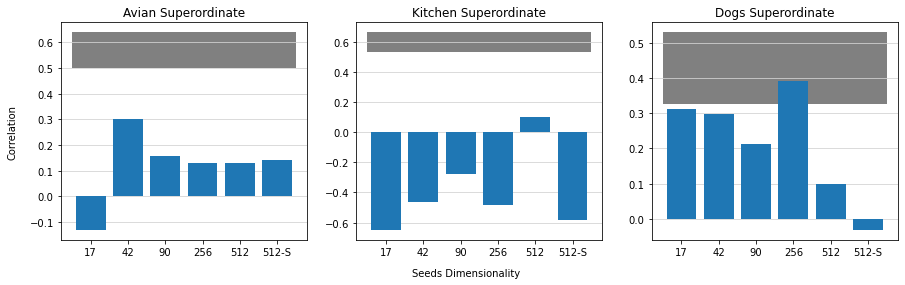

In [47]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,4))

ax1.bar([str(d) for d in dims], seed_sem['ave'],)
ax1.grid(color='lightgrey', linestyle='-', axis='y')
ax1.set_axisbelow(True)
#ax1.set_ylim([-0.0, 0.3])
ax1.set_title('Avian Superordinate')
ax1.add_patch(
    matplotlib.patches.Rectangle(
        xy=(-0.5, noise['ave'][0]),  # point of origin.
        width=6, height=noise['ave'][1]-noise['ave'][0], linewidth=0,
        color='grey', fill=True, zorder=0))

ax2.bar([str(d) for d in dims], seed_sem['kitchen'])
ax2.grid(color='lightgrey', linestyle='-', axis='y',)
ax2.set_axisbelow(True)
#ax2.set_ylim([-0.8, 0.4])
ax2.set_title('Kitchen Superordinate')
ax2.add_patch(
    matplotlib.patches.Rectangle(
        xy=(-0.5, noise['kitchen'][0]),  # point of origin.
        width=6, height=noise['kitchen'][1]-noise['kitchen'][0], linewidth=0,
        color='grey', fill=True, zorder=0))

ax3.bar([str(d) for d in dims], seed_sem['dog'])
ax3.grid(color='lightgrey', linestyle='-', axis='y')
#ax3.set_ylim([0, 0.5])
ax3.set_title('Dogs Superordinate')
ax3.add_patch(
    matplotlib.patches.Rectangle(
        xy=(-0.5, noise['dog'][0]),  # point of origin.
        width=6, height=noise['dog'][1]-noise['dog'][0], linewidth=0,
        color='grey', fill=True, zorder=0))
ax3.set_axisbelow(True)

fig.text(0.5, 0.01, 'Seeds Dimensionality', ha='center', va='center')
fig.text(0.08, 0.5, 'Correlation', ha='center', va='center', rotation='vertical')
#fig.savefig('rsa_main.png',bbox_inches='tight', dpi=300)

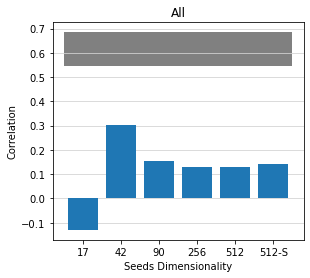

In [44]:
# Compare the ALL RDMs to each other
fig, ax1 = plt.subplots(figsize=(4.5,4))

ax1.bar([str(d) for d in dims], seed_sem['ave'],)
ax1.grid(color='lightgrey', linestyle='-', axis='y')
ax1.set_axisbelow(True)
#ax1.set_ylim([-0.0, 0.3])
ax1.set_title('All')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Seeds Dimensionality')
ax1.add_patch(
    matplotlib.patches.Rectangle(
        xy=(-0.5, noise['all'][0]),  # point of origin.
        width=6, height=noise['all'][1]-noise['all'][0], linewidth=0,
        color='grey', fill=True, zorder=0))
fig.savefig('rsa_main_all.png',bbox_inches='tight', dpi=300)

Seed vs Seed

In [29]:
svs = np.zeros((len(dims), len(dims)))

for i, d in enumerate(dims):
    for j, k in enumerate(dims):
        svs[i,j] = float(rsatoolbox.rdm.compare(seed_rdm[d]['ave'], seed_rdm[k]['ave'], method='rho-a'))

svs2 = np.zeros((len(dims), len(dims)))

for i, d in enumerate(dims):
    for j, k in enumerate(dims):
        svs2[i,j] = float(rsatoolbox.rdm.compare(seed_rdm[d]['kitchen'], seed_rdm[k]['kitchen'], method='rho-a'))

svs3 = np.zeros((len(dims), len(dims)))

for i, d in enumerate(dims):
    for j, k in enumerate(dims):
        svs3[i,j] = float(rsatoolbox.rdm.compare(seed_rdm[d]['dog'], seed_rdm[k]['dog'], method='rho-a'))

In [30]:
mx = np.max([np.max(svs), np.max(svs2), np.max(svs3)])
mn = np.min([np.min(svs), np.min(svs2), np.min(svs3)])
svs = (svs-mn)/(mx-mn)
svs2 = (svs2-mn)/(mx-mn)
svs3 = (svs3-mn)/(mx-mn)

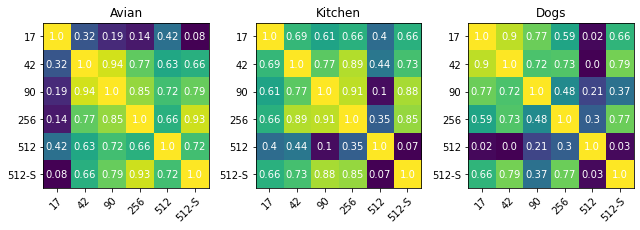

0.656309585716762 0.6686167446697867 0.5744063095857167
0.0876890239705041 0.07916142048698066 0.11216799584908804


In [47]:
fig, (ax, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 4))
im = ax.imshow(svs)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(dims)))
ax.set_xticklabels(dims)
ax.set_yticks(np.arange(len(dims)))
ax.set_yticklabels(dims)
ax.set_title('Avian')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dims)):
    for j in range(len(dims)):
        text = ax.text(j, i, np.round(svs[i, j], 2),
                       ha="center", va="center", color="w")

im = ax2.imshow(svs2)
# Show all ticks and label them with the respective list entries
ax2.set_xticks(np.arange(len(dims)))
ax2.set_xticklabels(dims)
ax2.set_yticks(np.arange(len(dims)))
ax2.set_yticklabels(dims)
ax2.set_title('Kitchen')

# Rotate the tick labels and set their alignment.
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dims)):
    for j in range(len(dims)):
        text = ax2.text(j, i, np.round(svs2[i, j], 2),
                       ha="center", va="center", color="w")

im = ax3.imshow(svs3)
# Show all ticks and label them with the respective list entries
ax3.set_xticks(np.arange(len(dims)))
ax3.set_xticklabels(dims)
ax3.set_yticks(np.arange(len(dims)))
ax3.set_yticklabels(dims)
ax3.set_title('Dogs')

# Rotate the tick labels and set their alignment.
plt.setp(ax3.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(dims)):
    for j in range(len(dims)):
        text = ax3.text(j, i, np.round(svs3[i, j], 2),
                       ha="center", va="center", color="w")

#ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()
fig.savefig('seeds_vs_seeds_corr.png', dpi=300)
print(np.mean(svs), np.mean(svs2), np.mean(svs3))
print(np.var(svs), np.var(svs2), np.var(svs3))

Visualisations

In [41]:
minmax = {}

for g in ['ave', 'kitchen', 'dog', 'all']:
    mns = []
    mxs = []
    for d in dims:
        mns.append(np.min(seed_rdm[d][g].get_matrices()))
        mxs.append(np.max(seed_rdm[d][g].get_matrices()))
    minmax[g] = [np.min(mns), np.max(mxs)]

In [42]:
a = [x[0] for k, x in minmax.items() if k!='all']
a.append(minmax2[0])
b = [x[1] for k, x in minmax.items() if k!='all']
b.append(minmax2[1])
global_min = np.min(a)
global_max = np.max(b)

In [40]:
minmax2 = []
mns = []
mxs = []

for g in ['ave', 'kitchen', 'dog']:
    mns.append(np.min(sem_rdm[g].get_matrices()))
    mxs.append(np.max(sem_rdm[g].get_matrices()))
minmax2 = [np.min(mns), np.max(mxs)]

In [32]:
def normalise_rdm(rdm, mn, mx):
    return (rdm - mn)/(mx - mn)

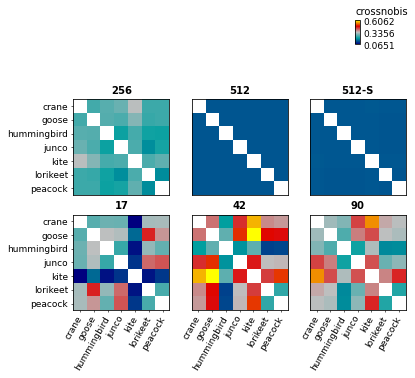

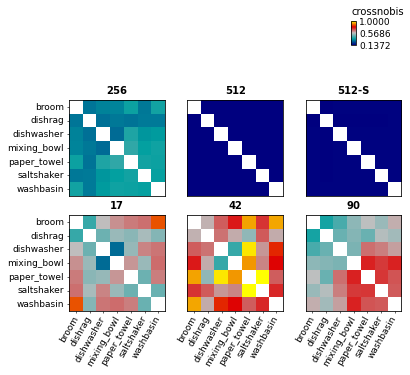

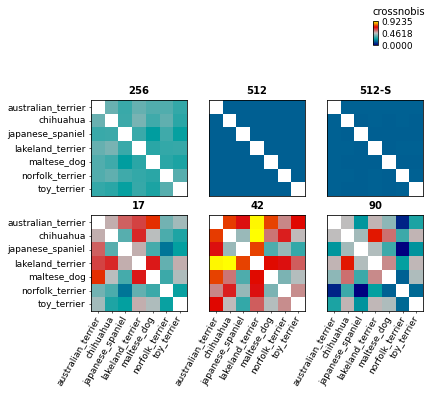

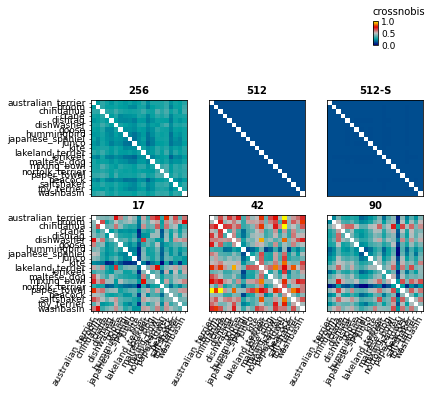

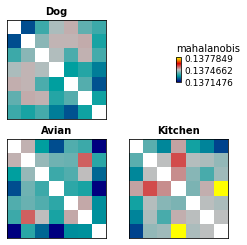

In [45]:
con = rsatoolbox.rdm.concat([rsatoolbox.rdm.RDMs(normalise_rdm(seed_rdm[d]['ave'].get_matrices(), global_min, global_max), rdm_descriptors={'name':str(d)}, pattern_descriptors=seed_rdm[d]['ave'].pattern_descriptors, dissimilarity_measure="crossnobis") for d in dims],)
con2 = rsatoolbox.rdm.concat([rsatoolbox.rdm.RDMs(normalise_rdm(seed_rdm[d]['kitchen'].get_matrices(), global_min, global_max), rdm_descriptors={'name':str(d)}, pattern_descriptors=seed_rdm[d]['kitchen'].pattern_descriptors, dissimilarity_measure="crossnobis") for d in dims],)
con3 = rsatoolbox.rdm.concat([rsatoolbox.rdm.RDMs(normalise_rdm(seed_rdm[d]['dog'].get_matrices(), global_min, global_max), rdm_descriptors={'name':str(d)}, pattern_descriptors=seed_rdm[d]['dog'].pattern_descriptors, dissimilarity_measure="crossnobis") for d in dims],)
con4 = rsatoolbox.rdm.concat([rsatoolbox.rdm.RDMs(normalise_rdm(seed_rdm[d]['all'].get_matrices(), minmax['all'][0], minmax['all'][1]), rdm_descriptors={'name':str(d)}, pattern_descriptors=seed_rdm[d]['all'].pattern_descriptors, dissimilarity_measure="crossnobis") for d in dims],)
con5 = rsatoolbox.rdm.concat([rsatoolbox.rdm.RDMs(normalise_rdm(sem_rdm[d].get_matrices(), global_min, global_max), rdm_descriptors={'name':'Avian' if d=='ave' else 'Dog' if d=='dog' else 'Kitchen'}, pattern_descriptors=sem_rdm[d].pattern_descriptors, dissimilarity_measure="mahalanobis") for d in ['ave', 'kitchen', 'dog']],)
# con = rsatoolbox.rdm.rank_transform(con)
# con2 = rsatoolbox.rdm.rank_transform(con2)
# con3 = rsatoolbox.rdm.rank_transform(con3)
# con4 = rsatoolbox.rdm.rank_transform(con4)

fig, ax, ret_val = rsatoolbox.vis.show_rdm((con),
             rdm_descriptor='name',
             show_colorbar='figure',
             pattern_descriptor='class',)
fig.savefig('rdm_ave.png', bbox_inches='tight', dpi=300)
fig, ax, ret_val = rsatoolbox.vis.show_rdm((con2),
             rdm_descriptor='name',
             show_colorbar='figure',
             pattern_descriptor='class',)
fig.savefig('rdm_kit.png', bbox_inches='tight', dpi=300)
fig, ax, ret_val = rsatoolbox.vis.show_rdm((con3),
             rdm_descriptor='name',
             show_colorbar='figure',
             pattern_descriptor='class',)
fig.savefig('rdm_dog.png', bbox_inches='tight', dpi=300)
fig, ax, ret_val = rsatoolbox.vis.show_rdm((con4),
             rdm_descriptor='name',
             show_colorbar='figure',
             pattern_descriptor='class',icon_spacing=200)
fig.savefig('rdm_all.png', bbox_inches='tight', dpi=300)
#sem_rdm['ave'].rdm_descriptors = {'name':['Avian']}
# sem_rdm['ave'].dissimilarity_measure = 'mahalanobis'
# fig, ax, ret_val = rsatoolbox.vis.show_rdm((sem_rdm['ave']),
#              rdm_descriptor='Avian Subset',
#              show_colorbar='figure',
#              pattern_descriptor='class',)
# fig.savefig('rdm_ave_sem.png', bbox_inches='tight', dpi=300)
# sem_rdm['kitchen'].dissimilarity_measure = 'mahalanobis'
# fig, ax, ret_val = rsatoolbox.vis.show_rdm((sem_rdm['kitchen']),
#              rdm_descriptor='Kitchen Subset',
#              show_colorbar='figure',
#              pattern_descriptor='class')
# fig.savefig('rdm_kit_sem.png', bbox_inches='tight', dpi=300)
# fig, ax, ret_val = rsatoolbox.vis.show_rdm((sem_rdm['dog']),
#              rdm_descriptor='Dog Subset',
#              show_colorbar='figure',
#              pattern_descriptor='class')
# fig.savefig('rdm_dog_sem.png', bbox_inches='tight', dpi=300)
fig, ax, ret_val = rsatoolbox.vis.show_rdm((con5),
             rdm_descriptor='name',
             show_colorbar='figure',)
fig.savefig('rdm_all_sem.png', bbox_inches='tight', dpi=300)
# rsatoolbox.vis.show_rdm((sem_rdm['kitchen']),
#              rdm_descriptor='Semantic Avian Subset',
#              show_colorbar='figure',
#              pattern_descriptor='class')

Model comparisons

In [ ]:
model = rsatoolbox.model.ModelInterpolate('test', con)
mo = model.predict_rdm()
a = float(rsatoolbox.rdm.compare(mo, sem_rdm['ave'], method='rho-a'))
model = rsatoolbox.model.ModelInterpolate('test', con2)
mo = model.predict_rdm()
b = float(rsatoolbox.rdm.compare(mo, sem_rdm['kitchen'], method='rho-a'))
model = rsatoolbox.model.ModelInterpolate('test', con3)
mo = model.predict_rdm()
c = float(rsatoolbox.rdm.compare(mo, sem_rdm['dog'], method='rho-a'))

In [53]:
print(a,b,c)

0.06363636363636364 -0.24025974025974023 0.06233766233766234


Text(0.5, 0, 'Seeds Dimensionality')

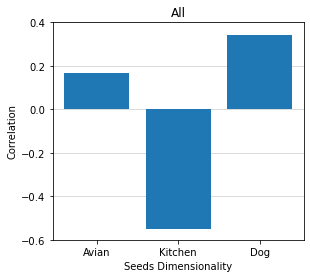

In [49]:
fig, ax1 = plt.subplots(figsize=(4.5,4))

ax1.bar(['Avian', 'Kitchen', 'Dog'], [a,b,c],)
ax1.grid(color='lightgrey', linestyle='-', axis='y')
ax1.set_axisbelow(True)
ax1.set_ylim([-0.6, 0.4])
ax1.set_title('All')
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Seeds Dimensionality')
#fig.savefig('rsa_model.png',bbox_inches='tight', dpi=300)

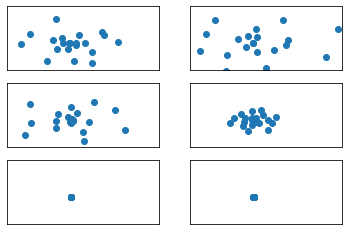

In [51]:
con_a = rsatoolbox.rdm.concat([rsatoolbox.rdm.RDMs(seed_rdm[d]['all'].get_matrices(), rdm_descriptors={'name':str(d)}, pattern_descriptors=seed_rdm[d]['all'].pattern_descriptors, dissimilarity_measure="crossnobis") for d in dims],)

a = rsatoolbox.vis.show_MDS(
    con_a,
)
#a.savefig('rsa_projection.png',bbox_inches='tight', dpi=300)

Get Mean Class Accuracies

In [ ]:
acc = [pd.DataFrame(columns=['group', 'class', 4, 17, 42, 90, 256, 512]) for i in range(3)]
acc_baseline = pd.DataFrame(columns=['group', 'class', 4, 17, 42, 90, 256])
#sparsity = pd.DataFrame(columns=['group', 'class', 4, 17, 42, 90, 256])
ws = []

for cl in classes:
    for i in range(3):
        acc[i] = acc[i].append({'group':'ave' if cl in ave else 'dog' if cl in dogs else 'kitchen', 'class':cl, 4:0, 17:0, 42:0, 90:0, 256:0, 512:0}, ignore_index=True)
    acc_baseline = acc_baseline.append({'group':'ave' if cl in ave else 'dog' if cl in dogs else 'kitchen', 'class':cl, 4:0, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)
    #sparsity = sparsity.append({'group':'ave' if cl in ave else 'kitchen', 'class':cl, 4:0, 17:0, 42:0, 90:0, 256:0}, ignore_index=True)

#Begin the tests for each class (baseline)
for dim in [17, 42, 90, 256, 512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    model.load_weights(f'models/baseline_fixed/{dim}/model_weights')
    for cl in classes:
        test_set.set_target_sampling([cl], [1])
        acc_val = test_model(model, test_set, cl)
        acc_baseline.loc[classes.index(cl), dim] = acc_val

# Begin the tests for each class (target)
for dim in [17, 42, 90, 256, 512]:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in classes:
        test_set.set_target_sampling([cl], [1])
        for j, i in enumerate(['',]):
            model.load_weights(f'models/task_models_fixed/{cl}/{str(dim)}/model_weights{i}')
            acc_val = test_model(model, test_set, cl)
            acc[j].loc[classes.index(cl), dim] = acc_val

In [62]:
#acc = np.vstack([acc[i][dims] for i in range(3)])
for i in ['ave', 'kitchen', 'dog']:
    print(np.mean(acc[0][acc[0]['group']==i][dims], axis=0))

17     0.862600
42     0.871529
90     0.894685
256    0.933221
512    0.945007
dtype: float64
17     0.729627
42     0.773026
90     0.811012
256    0.861015
512    0.855184
dtype: float64
17     0.641691
42     0.730729
90     0.813819
256    0.879592
512    0.876793
dtype: float64


Class-Difficulty and Confusion Rates

In [ ]:
def test_model(model, test_set: CustomIterator, class_name) -> None:
    """ Test the passed model for its Top-1 accuracy on the passed test set.

    Args:
        model (Model): TensorFlow model.
        test_set (CustomIterator): Test set to test on.
    """
    test_set.reset()
    pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
    pred = np.argmax(pred, axis=-1)
    
    #print('Computing accuracy...')
    accuracy = np.sum(pred == test_set.class_indices[class_name])/len(pred)

    return accuracy

In [ ]:
# 40x40 Confusion Matrix
confusion_mat = [np.zeros((len(classes), len(classes))) for i in range(3)]
cl_idx = [test_set.class_indices[cl] for cl in classes]

for i, dim in enumerate(dims):
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])
    model.load_weights(f'models/baseline_fixed/{dim}/model_weights')

    for j, cl in enumerate(classes):
        test_set.set_target_sampling([cl], [1])
        pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
        pred = np.argmax(pred, axis=-1)
        for k in pred:
            if k in cl_idx:
                if k != test_set.class_indices[cl]:
                    confusion_mat[i][j, cl_idx.index(k)] = confusion_mat[i][j, cl_idx.index(k)] + 1

In [ ]:
# 40x1000 Confusion Vectors
conf_im = [np.zeros((len(classes), 1000)) for i in range(3)]
cl_idx = [test_set.class_indices[cl] for cl in classes]
test_set.reset()
for i, dim in enumerate([256]):
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])
    model.load_weights(f'models/baseline_fixed/{dim}/model_weights')

    for j, cl in enumerate(classes):
        test_set.set_target_sampling([cl], [1])
        pred = model.predict(test_set, steps=test_set.n//test_set.batch_size, verbose=0)
        pred = np.argmax(pred, axis=-1)
        for k in pred:
            if k != test_set.class_indices[cl]:
                conf_im[i][j, k] = conf_im[i][j, k] + 1

In [ ]:
# Find top 20 hardest and easiest classes then load their seed weights
with open('class_acc.pkl', 'rb') as f:
    acc_baseline  = pickle.load(f)
with open('seed_vals_final.pkl', 'rb') as f:
    s_dict  = pickle.load(f)
acc_baseline = dict(sorted(acc_baseline.items(), key=lambda item: item[1], reverse=False))
hard = list(acc_baseline.keys())[:20]
easy = list(acc_baseline.keys())[-20:]

In [ ]:
classes = easy + hard

In [ ]:
# Load seed weights for 20 hardest and easiest classes
s_dict = {d:{} for d in dims}

for dim in dims:
    model = tf.keras.models.load_model('models/vgg_trained')
    model.trainable = False
    model = insert_attention_layer_in_keras(p_mat_dict[dim], model, ['block5_conv1'])

    for cl in classes:
        model.load_weights(f'models/task_final/{cl}/{dim}/model_weights')
        s_dict[dim][cl] = model.get_layer('attention_block5_conv1').seeds.numpy()

In [ ]:
# Save them
with open('seed_vals_final.pkl', 'wb') as f:
    pickle.dump(s_dict, f)

In [ ]:
dims = [42, 90, 256]

In [ ]:
# Construct RDMs for the attention seeds
seed_rdm = {d:{} for d in dims}

for dim in dims:
    # Seeds
    dat = np.vstack(list(s_dict[dim].values()))
    data = rsatoolbox.data.Dataset(dat, obs_descriptors={'class': classes})
    seed_rdm[dim] = rsatoolbox.rdm.calc_rdm(data, method='mahlanobis', descriptor='class' )

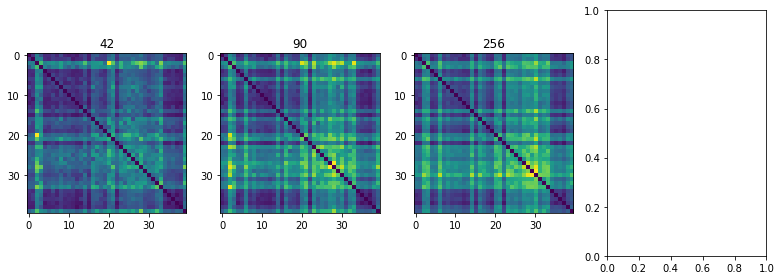

In [ ]:
fig, (ax, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(11, 4))
im = ax.imshow(seed_rdm[42].get_matrices()[0,:,:], interpolation='nearest')
ax.set_title('42')

im = ax2.imshow(seed_rdm[90].get_matrices()[0,:,:], interpolation='nearest')
ax2.set_title('90')

im = ax3.imshow(seed_rdm[256].get_matrices()[0,:,:], interpolation='nearest')
ax3.set_title('256')

fig.tight_layout()
#fig.savefig('hard_vs_easy.png',bbox_inches='tight', dpi=300)

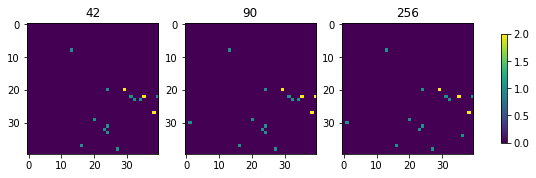

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
im = ax[0].imshow(confusion_mat[0],)
ax[0].set_title('42')
clim=im.properties()['clim']

ax[1].imshow(confusion_mat[1], clim=clim)
ax[1].set_title('90')

ax[2].imshow(confusion_mat[2], clim=clim)
ax[2].set_title('256')
#fig.subplots_adjust(right=2)
#cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.5)

#fig.tight_layout()
fig.savefig('conf_mat.png',bbox_inches='tight', dpi=300)

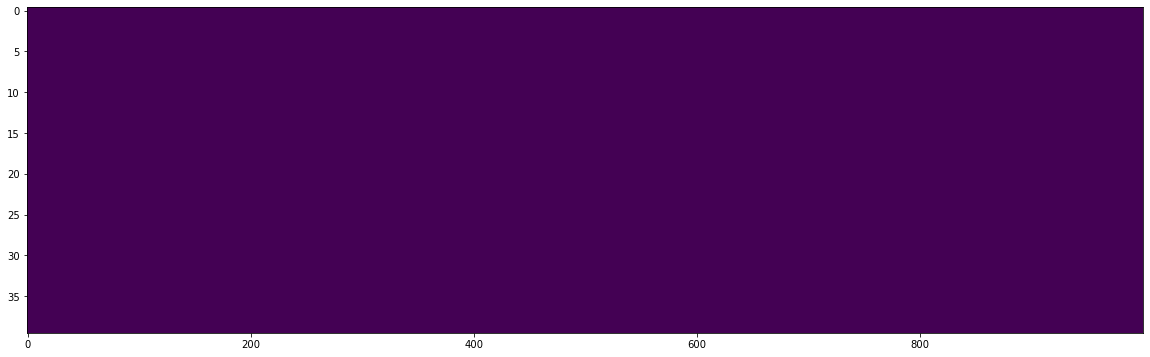

In [ ]:
fig, ax = plt.subplots(figsize=(20, 6))
im = ax.imshow(conf_im[2],aspect='auto', interpolation='nearest')
# ax3.set_yticks(np.arange(20))
# ax3.set_yticklabels(list(range(20)))
#fig.savefig('confusion_all.png',bbox_inches='tight', dpi=300)

In [ ]:
# Construct RDMs for confusion vectors
conf_rdm = {}

for d in dims:
    data = rsatoolbox.data.Dataset(conf_im[0], obs_descriptors={'class': classes})
    conf_rdm[d] = rsatoolbox.rdm.calc_rdm(data, method='mahalanobis', descriptor='class' )

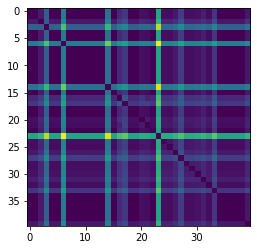

In [ ]:
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(conf_rdm[42].get_matrices()[0],aspect='auto', interpolation='nearest')
#fig.savefig('rdm_conf.png',bbox_inches='tight', dpi=300)

In [ ]:
# Compare each attention seeds RDM to its confusion vector RDM through Spearman corr
res = []

for d in dims:
    res.append(float(rsatoolbox.rdm.compare(seed_rdm[d], conf_rdm[d], method='rho-a')))

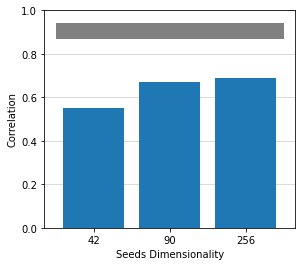

In [ ]:
fig, ax1 = plt.subplots(figsize=(4.5,4))

ax1.bar([str(d) for d in dims], res,)
ax1.grid(color='lightgrey', linestyle='-', axis='y')
ax1.set_axisbelow(True)
ax1.set_ylim([-0.0, 1])
ax1.set_ylabel('Correlation')
ax1.set_xlabel('Seeds Dimensionality')
ax1.add_patch(
    matplotlib.patches.Rectangle(
        xy=(-0.5, 0.8692083),  # point of origin.
        width=3, height=0.94113546-0.8692083, linewidth=0,
        color='grey', fill=True, zorder=0))
fig.savefig('confusion_res.png',bbox_inches='tight', dpi=300)